<a href="https://colab.research.google.com/github/jinhyung426/deeplearning.ai/blob/main/tf_chap4_Time_Series_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Part 4. Sequences, Time Series and Prediction

## (3) Predicting Real World Time Series Data with LSTM / RNN

# RNN

Assume input Shape = (batch_size=4, timestep=30, dimension=1).

- Each input x0, x1, ... x29 will output y0, y1, ... y29 which is (batch_size) X (number of units) (X dimension)
- Each cell state hn = yn
- Output: Y(hat) and H

# Sequence to Sequence RNN (example)

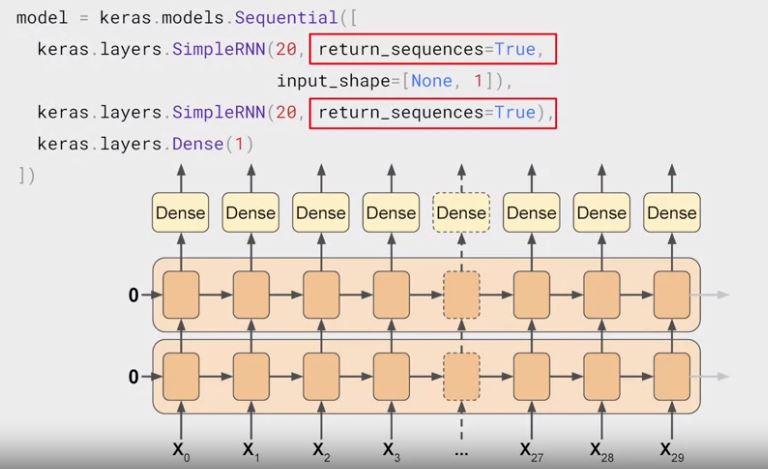

# Return Sequences

- **return_sequences = False**

  => we only get the last output which is y29
  
- **return_sequences = True**

  => it outputs a sequence y0, y1, ..., y29

  => If there is a following dense layer, it applies the "same" dense layer independently to each output of the sequence (reused)

# Downside of RNNs

(1) **Impacts diminish over timesteps**

(2) Use LSTM instead where the state is passed from cell to cell, timestep to timestep which enables data in the earlier part of the window can have bigger impact in the overall projection
than in the case of RNNs

(3) In addition to the H output, **LSTMs have a cell state that runs across all cells**

# Lambda Layers

- allows to **execute arbitrary code while training**
- ex. expand dimension for RNN input
```
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
```

- ex. rescaling
```
  tf.keras.layers.Lambda(lambda x: x * 100),
```



# Using LSTM to Predict Real World Time Series

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

tf.keras.backend.clear_session()
# clears any internal/temporary variables that tensorflow might have from previous sessions. 
# makes it easy to experiment without models impacting later versions of themselves

tf.random.set_seed(51)
np.random.seed(51)

In [2]:
# For colab - download the sunspot data which has a seasonality of 22 years but no trend
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-02-11 09:10:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.7.176, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2021-02-11 09:10:34 (140 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



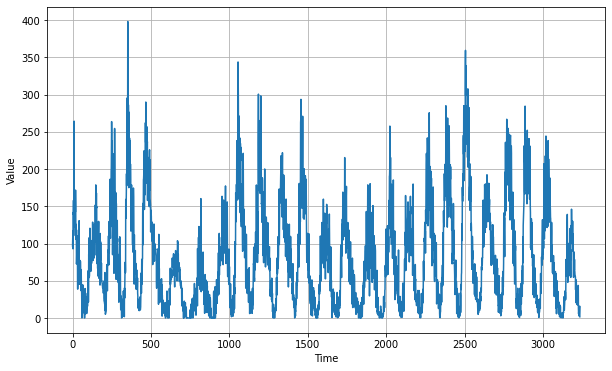

In [3]:
# Preprocess

timestep = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)
  for row in reader:
    timestep.append(int(row[0]))
    sunspots.append(float(row[2]))

series = np.array(sunspots)
time = np.array(timestep)
plt.figure(figsize=(10, 6))


def plot_series(time, series, start=0, end=None):
	plt.plot(time[start:end], series[start:end])
	plt.xlabel("Time")
	plt.ylabel("Value")
	plt.grid(True)


plot_series(time, series)

In [4]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)  # expand 1 dimension to use Conv1D
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)  # + 1 to account for label
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [5]:
def model_forecast(model, series, window_size):
  series = tf.expand_dims(series, axis=-1)    # expand 1 dimension to use Conv1D
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(32).prefetch(1)
  forecast = model.predict(dataset)
  return forecast

In [6]:
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)                 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * (10 ** (epoch / 20))
)
    
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=0, callbacks=[lr_schedule])

(1e-08, 0.0001, 0.0, 60.0)

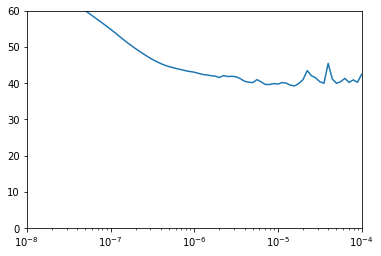

In [9]:
loss = history.history["loss"]
lr = history.history["lr"]
plt.semilogx(lr, loss)
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
# Since the optimal learning rate was  1e-5, we train it with that value

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
	tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
	tf.keras.layers.LSTM(64, return_sequences=True),
	tf.keras.layers.LSTM(64, return_sequences=True),
	tf.keras.layers.Dense(30, activation="relu"),
	tf.keras.layers.Dense(10, activation="relu"),
	tf.keras.layers.Dense(1),
	tf.keras.layers.Lambda(lambda x: x * 400)
])

# Use optimal learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=0)

<Figure size 432x288 with 0 Axes>

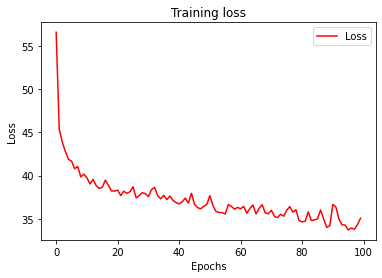

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

loss = history.history["loss"]
epochs = range(len(loss))

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

# Tips

1. If the loss is noisy then use a **bigger batch_size**
2. Try using a batch size, filters, window size that are **divisible from train data length**
3. Change loss
 - MSE : pushes bigger errors
 - MAE : dosesn’t heavily punish larger errors like square errors do


In [12]:
rnn_forecast = model_forecast(model, series, window_size)       # 일단 train + val data가 합쳐진 상태에서 예측
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0] # 그 후, validation period에 해당하는 부분만 truncate

29.189745

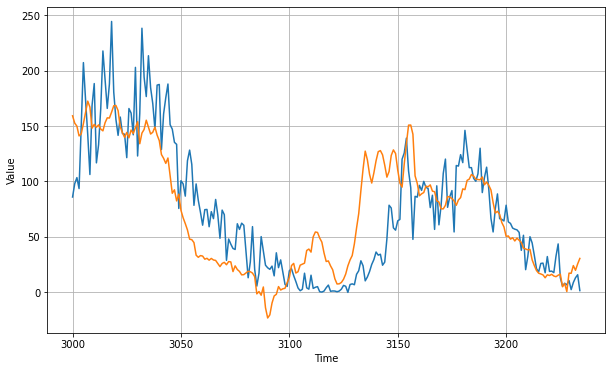

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()